In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dset

from torch.utils.data import DataLoader, sampler, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

plt.ion()   # interactive mode

In [2]:
class MOVIES(Dataset):

# A customized data loader for MNIST.\n",
    def __init__(self, images_folder, labels_doc, transform=None, preload=False, train=True):
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = images_folder
        self.transform = transform
        self.train = train
            
        all_filenames = pd.read_csv(labels_doc)        
        
        filenames = all_filenames['filename']
        
        ###labels are read in this order:
#         'Action', 'Thriller', 'Adventure', 'Animation', 'Western', 'Comedy', 
#         'Crime', 'Drama', 'Horror', 'Romance', 'Science Fiction', 'Fantasy', 
#         'Family', 'Documentary', 'History', 'Music', 'Mystery', 'TV Movie', 'War'
        labels = all_filenames[all_filenames.columns[2:]]
        
        for idx, fn in enumerate(filenames):
            self.filenames.append((fn, list(labels.iloc[idx]))) # (filename, labels)

        self.len = len(self.filenames)

    def __getitem__(self, index):
        
        image_fn, label = self.filenames[index]
        image = Image.open(self.root+image_fn)

        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            
        # return image and label
        return image, label
    
    def __len__(self):

#             Total number of samples in the dataset
        return self.len

In [3]:
image_folder = 'datasets/allPosters/'
Train_images_labels = 'Dataset_Training_3345.csv'
Val_images_labels = 'Dataset_Validation_955.csv'
Test_images_labels = 'Dataset_Test_479.csv'

BATCHSIZE = 3 #cifar10 set to 64
R_Mean = .4
G_Mean = .4
B_Mean = .4
R_Std = .01
G_Std = .01
B_Std = .01

In [4]:
data_transforms = T.Compose([
                T.Resize((224,224)),
                T.ToTensor()])


poster_train = MOVIES(image_folder, Train_images_labels, transform=data_transforms, train=True)
poster_val = MOVIES(image_folder, Val_images_labels, transform=data_transforms, train=True)
poster_test = MOVIES(image_folder, Test_images_labels, transform=data_transforms, train=True)

dataloaders = {}
dataloaders['train'] = DataLoader(poster_train, batch_size=BATCHSIZE)
dataloaders['val'] = DataLoader(poster_val, batch_size=BATCHSIZE)
dataloaders['test'] = DataLoader(poster_test, batch_size=BATCHSIZE)
    

In [5]:
poster_train[0][1]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 1,  0,  0]), tensor([ 1,  0,  1]), tensor([ 0,  1,  1]), tensor([ 0,  0,  0]), tensor([ 0,  1,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0])] [tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 1,  0,  0]), tensor([ 1,  0,  1]), tensor([ 0,  1,  1]), tensor([ 0,  0,  0]), tensor([ 0,  1,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0])] [tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 0,  0,  0]), tensor([ 1,  0,  0]), tensor([ 1,  0,  1]), tensor(

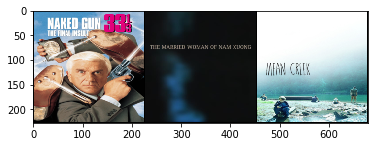

In [6]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels for j in range(BATCHSIZE)))

In [124]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [125]:
def flatten(x):
    N = x.shape[0] #read in N, C, H, W
    return x.view(N, -1) # "flatten" the C * H * W values into a sing le vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2) 
    print('Before flattening: ', x) 
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


In [126]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

In [127]:
def check_accuracy(loader, model): 
    if loader.dataset.train:
        print('Checking accuracy on validation set') 
    else:
        print('Checking accuracy on test set')

    num_correct = 0
    num_samples = 0
    model.eval() # set model to evaluation mode 
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples , 100 * acc))

In [128]:
def train_part(model, optimizer, epochs=1): 
    """
     - model: A PyTorch Module giving the model to train.
     - optimizer: An Optimizer object we will use to train the model
     - epochs: (Optional) A Python integer giving the number of epochs to train for
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device) # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(dataloaders['train']):
            model.train() # put model to training mode
            x = x.to(device=device, dtype=dtype) # move to device, e.
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            main_loss.append(loss)
            
            # Zero out all of the gradients for the variables which th
            # will update.
            
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gr
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %s' % (e))
                print('Iteration %d, loss = %.4f' % (t, loss.item())) 
                check_accuracy(loader_val, model)
                print()

In [129]:
channel_1 = 32
channel_2 = 16
channel_3 = 32
channel_4 = 16
learning_rate = .01
in_channel = 3
num_classes = 2
num_features = 3*32*32

main_loss = []

model = nn.Sequential(
#Layer 1
    nn.Conv2d(in_channel, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_1),
#Layer2
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(channel_2),
    #Layer2.2 ====> added in as an experiment
    nn.Conv2d(channel_2, channel_3, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_3),
#Layer3
    nn.Conv2d(channel_3, channel_4, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_4),
#Layer4
    Flatten(),
    nn.Linear((channel_4*32*32), num_classes)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

train_part(model, optimizer, epochs=5)

AttributeError: 'list' object has no attribute 'to'